In [152]:
#Ref : https://musicinformationretrieval.com/novelty_functions.html

import os
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import librosa
import librosa.display
import IPython.display as ipd

%matplotlib inline

print(sys.version)
print('librosa : ', librosa.__version__)
print('numpy : ', np.__version__)
print('scipy : ', sp.__version__)
print('matplotlib : ', mpl.__version__)

3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]
librosa :  0.5.1
numpy :  1.12.1
scipy :  1.0.1
matplotlib :  2.0.2


In [167]:
files = [os.path.join('./sample_audio', f) for f in os.listdir('./sample_audio') if os.path.isfile(os.path.join('./sample_audio', f))]
print(files)

#files = "./sample_audio/10sec.wav"

['./sample_audio\\10sec.wav', './sample_audio\\5sec.wav', './sample_audio\\kv598-normal.wav', './sample_audio\\kv598-varied.wav', './sample_audio\\kv598-varied2.wav']


# Enegry-based Novelty Functions
#### 1. Compute the short-time energy in the signal.
#### 2. Compute the first-order difference in the energy.
#### 3. Half-wave rectify the first-order difference.

(44100,) 22050
(87,)
(87,)


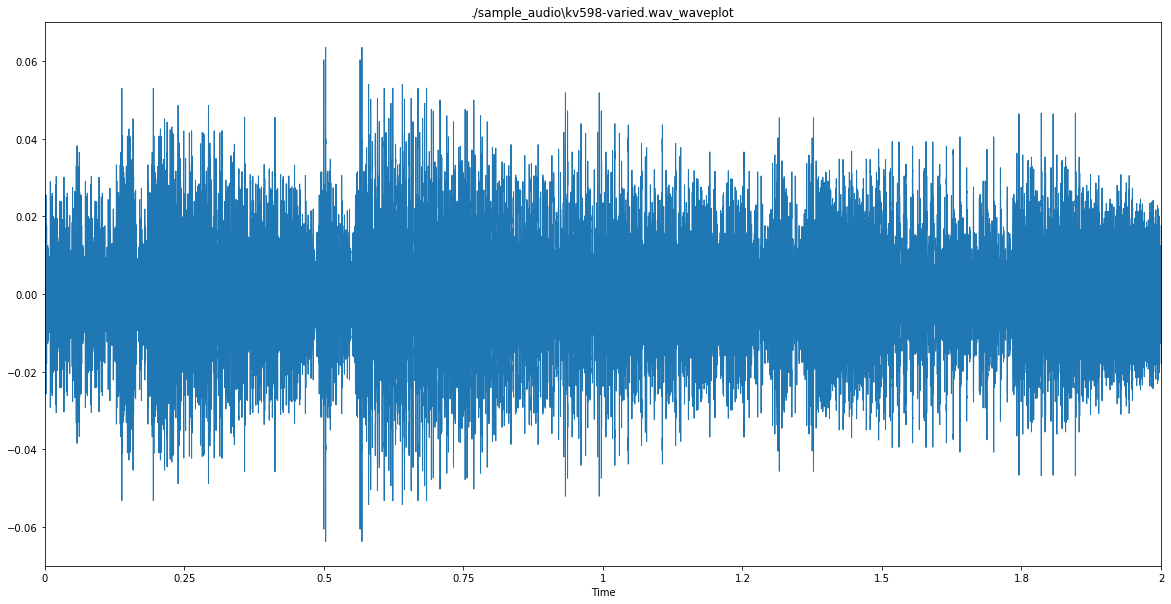

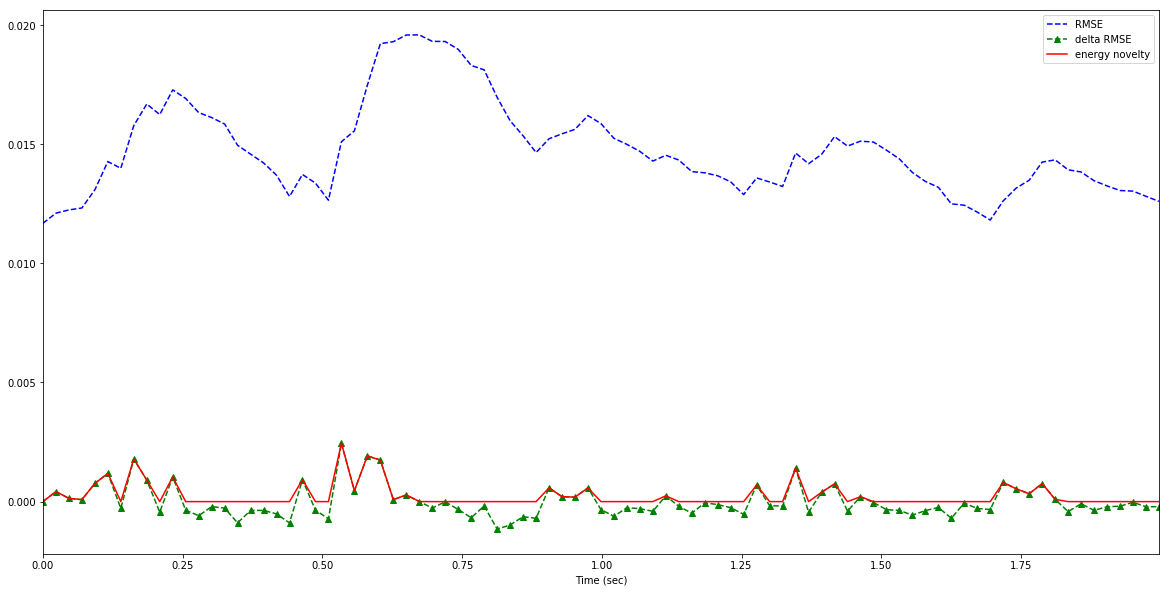

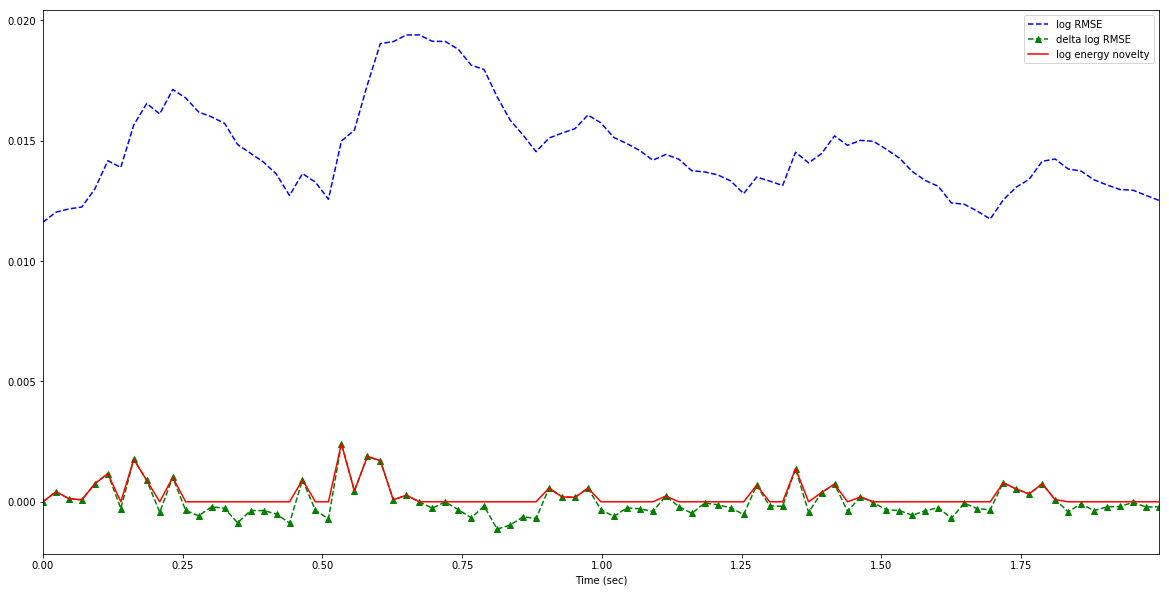

In [193]:
#for f in files:
    
y, sr = librosa.load(files[-1],offset = 8.0, duration = 2.0)
print(y.shape, sr)

plt.figure(figsize=(20,10))
librosa.display.waveplot(y,sr)
plt.title(f + "_waveplot")

# convention : frame_length = hop_length * 4
hop_length = 512
frame_length = 2048
rmse = librosa.feature.rmse(y, frame_length=frame_length, hop_length=hop_length).flatten()


#make same size array of rmse
rmse_diff = np.zeros_like(rmse)
# Calculate first-order difference. size = orignial size - 1
rmse_diff[1:] = np.diff(rmse)

print(rmse.shape)
print(rmse_diff.shape)

# half-wave rectiication
# max(0,x)
energy_novelty  = np.max([np.zeros_like(rmse_diff), rmse_diff], axis=0)

frames = np.arange(len(rmse))
t = librosa.frames_to_time(frames, sr=sr)

plt.figure(figsize=(20, 10))
plt.plot(t, rmse, 'b--', t, rmse_diff, 'g--^', t, energy_novelty, 'r-')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('RMSE', 'delta RMSE', 'energy novelty')) 


#make log scale for human perception 
# it's value is samll, so we take log1p

log_rmse = np.log1p(rmse)
log_rmse_diff = np.zeros_like(log_rmse)
log_rmse_diff[1:] = np.diff(log_rmse)

log_energy_novelty = np.max([np.zeros_like(log_rmse_diff), log_rmse_diff], axis = 0)

plt.figure(figsize=(20, 10))
plt.plot(t, log_rmse, 'b--', t, log_rmse_diff, 'g--^', t, log_energy_novelty, 'r-')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('log RMSE', 'delta log RMSE', 'log energy novelty')) 

In [194]:
#play audio
#ipd.Audio(y, rate=sr)

# Spectral-based Novelty Functions

### Why?

#### 1. It is sensitive to energy fluctuations belonging to the same note.
#### 2. It is not sensitive to spectral fluctuations between notes where amplitude remains the same.

### How to?

#### 1. Compute the log-amplitude spectrogram.
#### 2. Within each frequency bin,  kk , compute the energy novelty function as shown earlier, i.e. (a) first-order difference, and (b) half-wave rectification.
#### 3. Sum across all frequency bins,  kk .

(1025, 87)
(1025, 87)
(1025, 87)


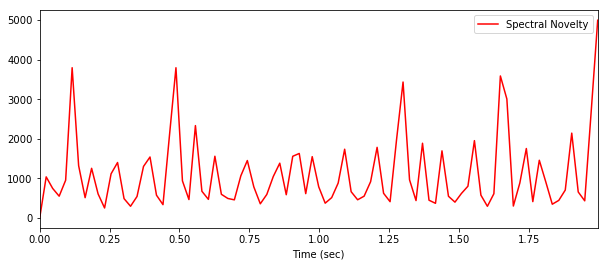

In [195]:


S = np.abs(librosa.stft(y))
print(S.shape)
power_S = librosa.power_to_db(S**2, ref = np.max)
print(power_S.shape)

power_S_diff = np.zeros_like(power_S)
#power_S_diff = np.diff(power_S, axis = 1)
power_S_diff[:,1:] = np.diff(power_S)

#power_S_diff = np.pad(power_S_diff, (1,0), 'constant', constant_values=(0))
print(power_S_diff.shape)


power_S_diff[power_S_diff<0] = 0

spectral_novelty = np.max([np.zeros_like(power_S_diff[1]), np.sum(power_S_diff, axis = 0)],axis = 0)

frames = np.arange(len(spectral_novelty))
t = librosa.frames_to_time(frames, sr=sr)


plt.figure(figsize=(10,  4))
plt.plot(t, spectral_novelty, 'r-')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('Spectral Novelty','Log Engery'))

87
87
87


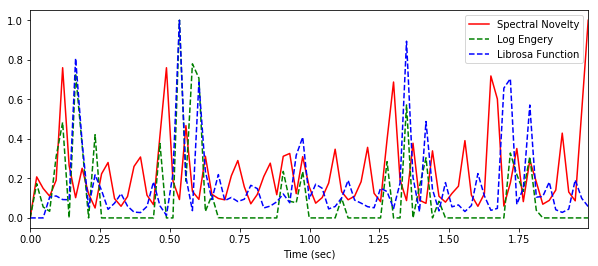

In [196]:
energy_novelty  = np.max([np.zeros_like(rmse_diff), rmse_diff], axis=0)
librosa_novelty = librosa.onset.onset_strength(y, sr=sr)

print(len(spectral_novelty))
print(len(energy_novelty))
print(len(librosa_novelty))

plt.figure(figsize=(10,  4))
plt.plot(t, spectral_novelty/np.max(spectral_novelty), 'r-', t, log_energy_novelty/np.max(log_energy_novelty), 'g--', t, librosa_novelty/np.max(librosa_novelty),'b--')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('Spectral Novelty','Log Engery', 'Librosa Function'))

In [197]:
x = np.array([[1, 3, 6, 10], [0, 5, 6, 8]])
print(np.diff(x,axis = 1))
print(np.diff(x, axis=0))


[[2 3 4]
 [5 1 2]]
[[-1  2  0 -2]]


[ 1.          0.22100435  0.35904828  0.29579732  0.2595697   0.33952072
  0.69940428  0.18504791  0.27824805  0.34407167  0.42503903  0.24450281
  0.33714062  0.18433844  0.11946305  0.2985753   0.29076802  0.35797606
  0.15354803  0.29775975  0.12799315  0.17986118  0.23932485  0.2223512
  0.3701939   0.46630254  0.33659884  0.20298998  0.23577417  0.16088679
  0.22783673  0.11533251  0.43645999  0.54815607  0.13905296  0.14711736
  0.17976382  0.17735738  0.32603479  0.24121282  0.24605025  0.19579938
  0.16750419  0.21501808  0.33030941  0.2540597   0.35065796]
[  0.23219955   0.44117914   0.62693878   0.83591837   1.021678
   1.20743764   1.41641723   1.62539683   1.81115646   2.02013605
   2.06657596   2.15945578   2.29877551   2.41487528   2.57741497
   2.69351474   2.80961451   2.94893424   3.06503401   3.20435374
   3.34367347   3.4829932    3.62231293   3.76163265   3.87773243
   3.97061224   4.08671202   4.57433107   4.64399093   4.99229025
   5.36380952   5.61922902   5.804

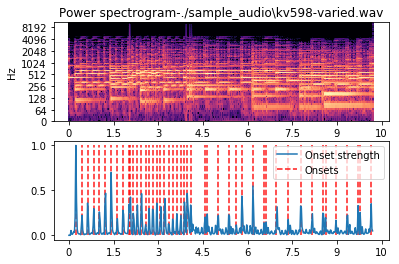

In [192]:
y, sr = librosa.load(files[-1])
y = librosa.util.normalize(y)
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)

o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

print(o_env[onset_frames])

D = librosa.stft(y)
plt.figure()
ax1 = plt.subplot(2, 1, 1)

librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log')

plt.title('Power spectrogram-'+f)
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(times, o_env, label='Onset strength')

plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,           # onset
           linestyle='--', label='Onsets')

print(times[onset_frames])

plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)
plt.show()

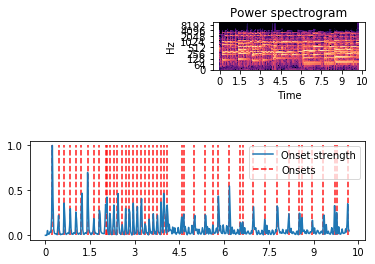

In [176]:
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)
o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

D = librosa.stft(y)
plt.figure()
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max), x_axis='time',y_axis='log')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)